#### Probabilistic PCA
In this note book we try to do dimensionality reduction using probabilistic pca
Estimating number of components jointly with lower dimension representation of data is a challenging task, here using hierarchical bayesian approach with dirichlet process on weights we infer number of components. 

In [ ]:
import inferpy as inf
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import h5py as h5
import numpy as np
from matplotlib import animation
from IPython.display import HTML

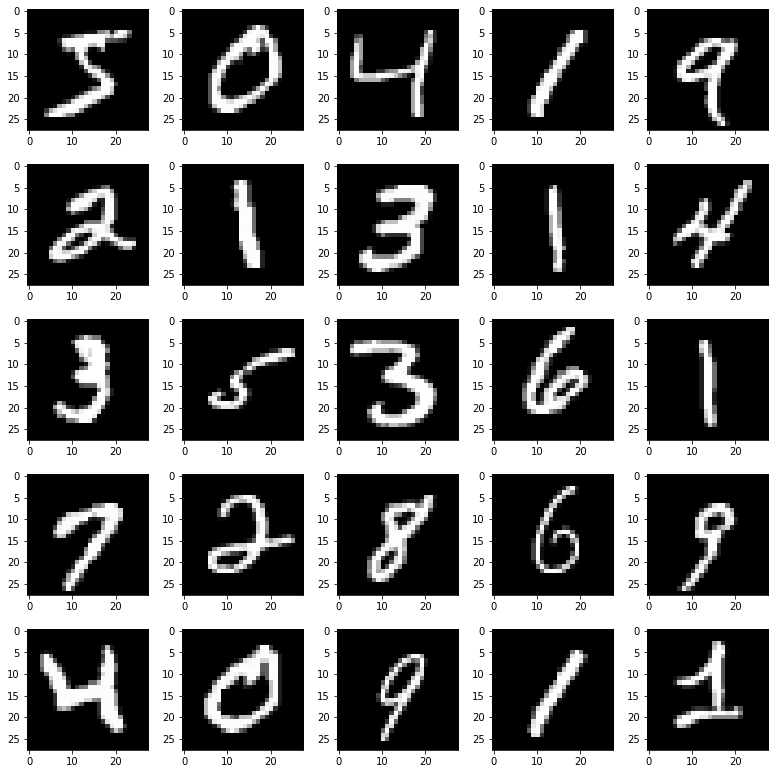

(60000, 784)
data contains non-positive elements
you sould use PCA based analysis


In [4]:
# input info 

# dimension of the data
data_dim = 28 *28

# dimension of hidden layer
hidden_dim = 30

# number of epochs for training
nr_epochs = 60000

# number of input image in each batch during training
nr_batch = 200

# digits in mnist
DIG = [0, 1, 3, 2, 4, 5, 6, 8, 9, 7]

# number of mnist samples
mnist_nr = 60000

# data selection custom or MNIST
MNIST = 1
Cust = not MNIST


# reading, reshaping input data

if MNIST==1:
    from inferpy.data import mnist
    N = mnist_nr
    # load the data
    (x_train, y_train), _ = mnist.load_data(num_instances=N, digits=DIG)
    mnist.plot_digits(x_train, grid=[5,5])
    print(x_train.shape)

if Cust:
    # loading custom data
    
    File = h5.File('data address in local machine', 'r')
    list(File.keys())
    data = np.array(File['key in custom data'])
    print(data.shape)
    x_train = data.reshape(-1,data_dim)
    print(x_train.shape)
    N = x_train.shape[0]
    
    
# Testing data
if x_train.min() <= 0:
    print('data contains non-positive elements')
    print('you sould use PCA based analysis')
else:
    print('data is all positive')
    print('you can use NMF analysis')

### Defining model & inference model

For likelihood (data) model we take multivariate normal with low rank model from inferpy package
Hidden variable (z) and transfer weights (w) are modeled with normal distribution
For weights we use dirichlet process with hierarchical priors beta and gamma distributions respectively

In [3]:
# Define a model
#tf.reset_default_graph() # reset the graph before defining model

# helper function to do dirichlet process prior on weights
def Stick_Breaking(betas):
    portion_remaining = tf.concat([[1], tf.cumprod(1 - betas)[:-1]], axis = 0)
    return betas*portion_remaining


# define model 
@inf.probmodel
def PCA(k, d):
    alpha = inf.Gamma(25,tf.ones([k]), name = 'alpha')
    beta = inf.Beta(1., alpha, name = 'beta')
    weight_ = inf.Deterministic(Stick_Breaking(beta), name = 'weight_')
    w = inf.Normal(loc = tf.zeros([k,d]), scale = 1, name = 'w')
    with inf.datamodel():
        z = inf.Normal(loc = tf.ones(k), scale = 1, name = 'z')
        x = inf.MultivariateNormalDiagPlusLowRank(
            loc = tf.matmul(z, tf.expand_dims(weight_, axis = 1) * w), name = 'x')
        

@inf.probmodel        
def qmodel(k, d):
    
    Param1 = tf.math.softplus(inf.Parameter(tf.ones([k]),
                                              name = 'Param1'))
    #Param2 = tf.math.softplus(inf.Parameter(tf.ones([k]),
     #                                         name = 'Param2'))
    
    qalpha = inf.Gamma(50, Param1, name = 'alpha')
    qbeta = inf.Beta(1., qalpha, name = 'beta')
    qweight_ = inf.Deterministic(Stick_Breaking(qbeta), name = 'weight_')
    
    qw_loc = inf.Parameter(tf.ones([k, d]), name = 'qw_loc')
    qw_scale = tf.math.softplus(inf.Parameter(tf.ones([k, d]),
                                              name = 'qw_scale'))
    qw = inf.Normal(loc = qw_loc, scale = qw_scale, name = 'w')
    
    with inf.datamodel():
        qz_loc = inf.Parameter(tf.ones(k), name = 'qz_loc')
        qz_scale = tf.math.softplus(inf.Parameter(tf.ones(k),
                                                  name = 'qz_scale'))
        qz = inf.Normal(loc = qz_loc, scale = qz_scale, name = 'z')
        

    
print('model function is defined')   

model function is defined


In [5]:
model_ = PCA(hidden_dim, data_dim)
qmodel_ = qmodel(hidden_dim, data_dim)

### Model inference
To do model inference on posterior we use variational inference technique which is provided in inferpy package
Adam optimization method is used as optimizer with learning rate of <0.001

In [6]:
# Inference
VI = inf.inference.VI(qmodel_, optimizer=tf.train.AdamOptimizer(learning_rate = 0.0005), 
                      epochs=nr_epochs)
model_.fit({'x': x_train- np.mean(x_train,axis=0)}, VI)


 0 epochs	 102906437632.0....................
 200 epochs	 102890504192.0....................
 400 epochs	 102875586560.0....................
 600 epochs	 102854737920.0....................
 800 epochs	 102809501696.0....................
 1000 epochs	 102770950144.0....................
 1200 epochs	 102732922880.0....................
 1400 epochs	 102664355840.0....................
 1600 epochs	 102581903360.0....................
 1800 epochs	 102497361920.0....................
 2000 epochs	 102476120064.0....................
 2200 epochs	 102352691200.0....................
 2400 epochs	 102355582976.0....................
 2600 epochs	 102017679360.0....................
 2800 epochs	 102092480512.0....................
 3000 epochs	 101901549568.0....................
 3200 epochs	 101884551168.0....................
 3400 epochs	 101644607488.0....................
 3600 epochs	 101555585024.0....................
 3800 epochs	 101446418432.0....................
 4000 epochs	 101275369472

 33400 epochs	 82302951424.0....................
 33600 epochs	 84306673664.0....................
 33800 epochs	 82715181056.0....................
 34000 epochs	 82008768512.0....................
 34200 epochs	 87283277824.0....................
 34400 epochs	 85313789952.0....................
 34600 epochs	 82644049920.0....................
 34800 epochs	 82367709184.0....................
 35000 epochs	 82552979456.0....................
 35200 epochs	 80597884928.0....................
 35400 epochs	 82198757376.0....................
 35600 epochs	 80051437568.0....................
 35800 epochs	 80899661824.0....................
 36000 epochs	 80050610176.0....................
 36200 epochs	 81787305984.0....................
 36400 epochs	 81261805568.0....................
 36600 epochs	 79163375616.0....................
 36800 epochs	 81091764224.0....................
 37000 epochs	 79173386240.0....................
 37200 epochs	 81807564800.0....................
 37400 epochs	 80919

### infering posterior using MCMC method
#### for very high dimensional data it seems convergence is very slow 

In [24]:

MC = inf.inference.MCMC(num_leapfrog_steps=5, num_burnin_steps=60000,num_results=300)
inf.__version__
model_.fit({'x': x_train-np.mean(x_train, axis = 0)}, MC)
z_samples_mean = np.mean(model_.posterior('z').parameters()['samples'], axis = 0)
w_samples_mean = np.mean(model_.posterior('w').parameters()['samples'], axis = 0)
print('Z_sample_mean', z_samples_mean.shape, 'W_sample_mean', w_samples_mean.shape)

'1.3.0'

Posterior parameters give parameter value for each random variable in the posterior distribution (example; z --> traces or w --> filters) 
Posterior sampling we get distribution for each element of each vaiable. For example get distribution (based on posterior distibution) for each pixel at filters or time point at races. Advantgae of this is getting uncertaintity over element. 

In [7]:
model_.posterior().parameters()

{'alpha': {'name': 'alpha',
  'allow_nan_stats': True,
  'validate_args': False,
  'rate': array([ 4.0652833,  3.0517867,  5.0304503,  5.2161617,  5.957747 ,
          5.94376  ,  4.972177 ,  5.279306 ,  5.6035843,  7.9734774,
          4.877214 ,  5.920435 ,  5.3828897,  8.751523 , 10.722291 ,
          9.249409 , 10.357039 ,  8.950016 ,  9.991635 ,  7.588208 ,
          9.513534 ,  7.774371 , 15.742898 , 16.811611 , 15.4892845,
         16.706179 , 14.956008 , 14.896372 , 18.011213 , 17.957197 ],
        dtype=float32),
  'concentration': 50},
 'beta': {'name': 'beta',
  'allow_nan_stats': True,
  'validate_args': False,
  'concentration0': array([13.176184 , 16.912535 , 11.143823 ,  8.489727 ,  9.124147 ,
          7.8671575,  9.263139 , 10.555648 ,  7.421107 ,  6.784775 ,
          8.888588 ,  7.73944  , 10.166553 ,  5.987043 ,  4.8087735,
          6.5431986,  3.8316302,  4.757522 ,  6.0878   ,  6.901407 ,
          5.468239 ,  6.135337 ,  3.913514 ,  3.380848 ,  2.9734952,
      

[9.62462276e-03 4.61200401e-02 1.19388945e-01 3.59565276e-03
 2.57317834e-02 1.03611201e-02 4.44047116e-02 5.83896898e-02
 7.29466416e-03 2.07797125e-01 1.27984183e-02 7.83946365e-03
 3.15577872e-02 2.09277440e-02 4.06534970e-02 2.17770273e-03
 1.49662822e-01 2.62576807e-02 1.94257144e-02 1.07972452e-03
 7.32697099e-02 1.43713774e-02 2.58286633e-02 1.06067478e-03
 1.63403034e-04 2.32768189e-02 9.07467562e-04 2.11536628e-03
 3.28846555e-03 1.96407479e-03]


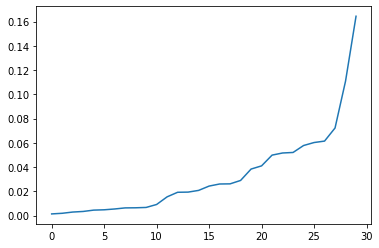

In [8]:
plt.plot(np.sort(model_.posterior('weight_').parameters()['loc']))
Weights_ = model_.posterior('weight_').parameters()['loc']
print(Weights_)
#model_.posterior('beta').parameters()['concentration']
#plt.hist(model_.posterior('beta').parameters()['concentration'])
#print(np.mean(model_.posterior('beta').sample(1000),axis = 0))

In [9]:
# posterior  parameters
z_loc = model_.posterior('z').parameters()['loc']

w_loc = model_.posterior('w').parameters()['loc']


In [10]:
def plot_params(filters, traces, Weights):
    plt.figure(figsize=(30,20))
    for i in range(filters.shape[0]):
        filters[i] = Weights[i] * filters[i]
    
    min_ = filters.min()
    max_ = filters.max()
    for i in range(30):
        plt.subplot(10,8,i*2+1)
        plt.imshow(filters[i], vmin=min_, vmax=max_)
        plt.axis('off')
        plt.title(i)
        plt.subplot(10,8,i*2+2)
        plt.plot(traces[i])
        plt.title(i)

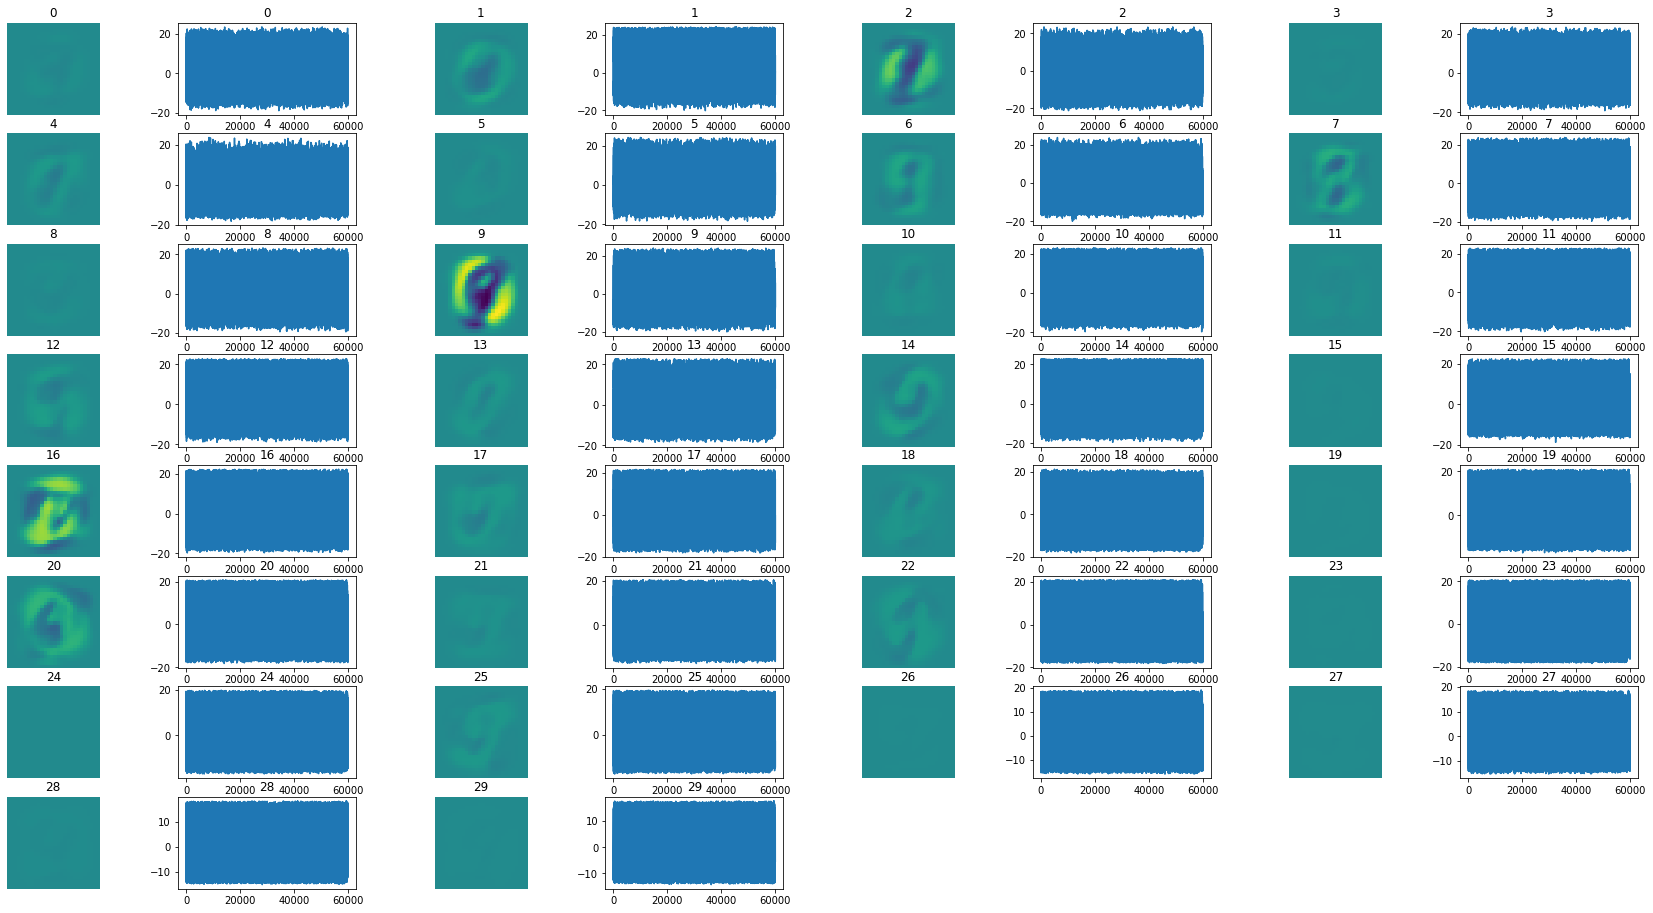

In [11]:
plot_params(w_loc.reshape(-1,28,28), z_loc.T, Weights_)